In [2]:
import pandas as pd 
import numpy as np
import os 
import joblib

from rdkit import Chem
from mapchiral import mapchiral
import tmap as tm 
from rdkit import Chem
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams.update({'font.size': 10})

from evaluation_functions import *

from tqdm import tqdm
tqdm.pandas()

## TMAP: COCONUT DB

#### Import data frame

Read previously generated data frame

In [3]:
coconut = pd.read_csv('data/coconut/coconut_clean_splits.csv')

Add chemical class

In [4]:
peptide = '[NX3,NX4+][CH1,CH2][CX3](=[OX1])[NX3,NX4+][CH1,CH2][CX3](=[OX1])[O,N]'
sugar = '[CR][OR][CHR]([OR0,NR0])[CR]'

def match_pattern(row, pattern, name):
    mol = Chem.MolFromSmiles(row['absolute_smiles'])
    if mol.HasSubstructMatch(Chem.MolFromSmarts(pattern)):
        return name 
    else:
        return row['chemical_class_new']

def clean_chemical_class(chemical_class): 
    if chemical_class == '"Lipids and lipid-like molecules"':
        return 'Lipids & Terpenes'
    elif chemical_class == '"Phenylpropanoids and polyketides"':
        return 'Polyketides'
    elif chemical_class == '"Alkaloids and derivatives"':
        return 'Alkaloids'
    elif chemical_class == '"Benzenoids"':
        return 'Benzenoids'
    elif chemical_class == 'Peptides':
        return 'Peptides'
    elif chemical_class == '"Lignans, neolignans and related compounds"':
        return 'Lignans'
    elif chemical_class == '"Nucleosides, nucleotides, and analogues"':
        return 'Nucleosides'
    elif chemical_class == 'Glycosides':
        return 'Glycosides'
    else:
        return 'Other'

coconut['chemical_class_new'] = coconut['chemical_super_class'].values.tolist()
coconut['chemical_class_new'] = coconut.apply(lambda x: match_pattern(x, sugar, 'Glycosides'), axis=1)
coconut['chemical_class_new'] = coconut.apply(lambda x: match_pattern(x, peptide, 'Peptides'), axis=1)
coconut['chemical_class_new'] = coconut['chemical_class_new'].apply(clean_chemical_class)

Clean number of stereocenters

In [5]:
coconut['num_stereocenters_new'] = coconut['num_stereocenters'].apply(lambda x: x if x <= 10 else 11)
coconut['num_stereoisomers_new'] = coconut['num_stereoisomers'].apply(lambda x: x if x <= 10 else 11)

#### 3D bar plot

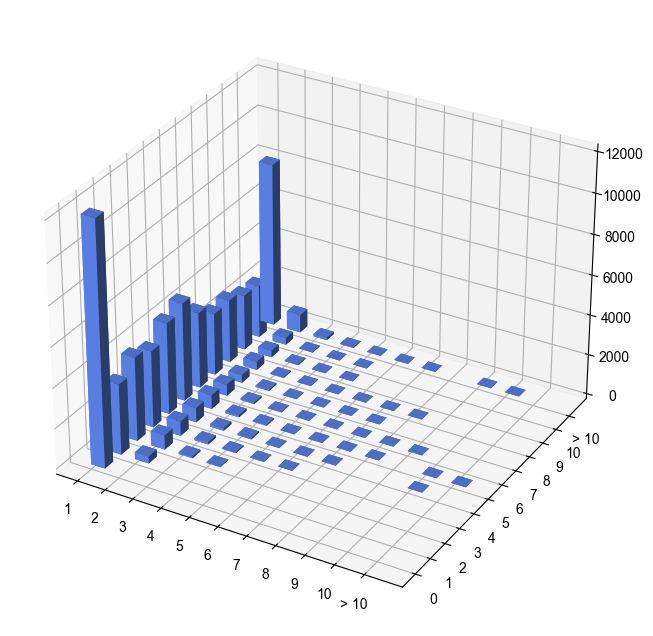

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Group by the new numeric columns and count the number of compounds in each group
grouped = coconut.groupby(['num_stereocenters_new', 'num_stereoisomers_new']).size().reset_index(name='counts')

# Create the figure and 3D axis with a larger size
fig = plt.figure(figsize=(10, 8))  # Increase the figure size (width, height)
ax = fig.add_subplot(111, projection='3d')

# Assign x, y, and z values from the grouped data (switching x and y)
x = grouped['num_stereoisomers_new']
y = grouped['num_stereocenters_new']
z = grouped['counts']

# Generate bar positions for a 3D plot
dx = dy = 0.5  # Set the width of bars
dz = z  # Height of bars is based on counts

# Plot the 3D bar plot with custom color
ax.bar3d(x, y, np.zeros_like(z), dx, dy, dz, shade=True, color='#648FFF')

# Adjust the tick labels to reflect 'above 10' category
ax.set_xticks(list(grouped['num_stereoisomers_new'].unique()))
ax.set_xticklabels([str(i) if i != 11 else '> 10' for i in grouped['num_stereoisomers_new'].unique()])

ax.set_yticks(list(grouped['num_stereocenters_new'].unique()))
ax.set_yticklabels([str(i) if i != 11 else '> 10' for i in grouped['num_stereocenters_new'].unique()])

# Show the plot
plt.savefig('plots/3d_barplot_stereocenters_stereoisomers.png', dpi=1200)

Calculate MAP4C fingerprints

In [8]:
if not os.path.exists('data/fingerprints/coconut_map4c.joblib'):
    coconut['map4c'] = coconut['absolute_smiles'].apply(lambda x: mapchiral.encode(Chem.MolFromSmiles(x), max_radius=2, n_permutations=2048))
    joblib.dump(coconut['map4c'], 'data/fingerprints/coconut_map4c.joblib')
else:
    coconut['map4c'] = joblib.load('data/fingerprints/coconut_map4c.joblib')

#### TMAP

Generate layout

In [9]:
if not os.path.exists(f'plots/tmaps/layouts/coconut_layout.pkl'):
    
    lf = tm.LSHForest(2048, 32)

    map4 = np.array(coconut['map4c'])
    fps = []

    for i in map4:
        vec = tm.VectorUint(i)
        fps.append(vec)

    lf.batch_add(fps)
    lf.index()

    cfg = tm.LayoutConfiguration() #configuration parameters for tmap layout
    cfg.node_size = 1/32.5 #size of nodes which affects the magnitude of their repelling force. Decreasing this values generally resolves overlaps in a very crowded tree
    cfg.mmm_repeats = 2 #number of repeats of the per-level layout algorithm
    cfg.sl_extra_scaling_steps = 5 #sets the number of repeats of the scaling
    cfg.k = 20 #number of nearest neighbours used to create the k-nearest neighbour graph
    cfg.sl_scaling_type = tm.RelativeToAvgLength #Defines the relative scale of the graph
    x, y, s, t, _ = tm.layout_from_lsh_forest(lf, cfg)
    tm_layout = {'x': list(x), 'y': list(y), 's': list(s), 't': list(t)}
    joblib.dump(tm_layout, f'plots/tmaps/layouts/coconut_layout.pkl')
else:
    tm_layout = joblib.load(f'plots/tmaps/layouts/coconut_layout.pkl')

TMAP: number of stereocenters

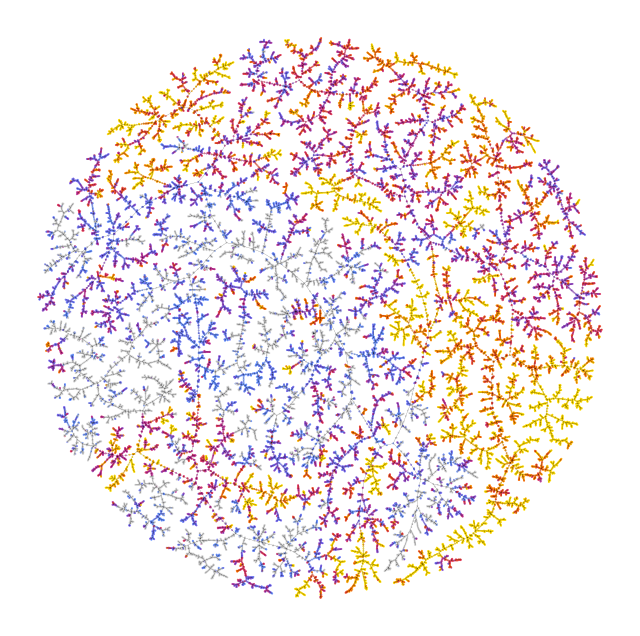

In [17]:
nstereo_colors = {'0': '#D6D6D6', '1': '#648FFF', '2': '#6D79F8', '3': '#7663F2', '4': '#994BCA', '5': '#C63298', '6': '#E43363', '7': '#F34D2A', '8': '#FE6A00', '9': '#FF8D00', '10': '#FFB000', '>10': '#FFDD00'}
colors = coconut['num_stereocenters_new'].map(nstereo_colors)

x, y = tm_layout['x'], tm_layout['y']

plt.figure(figsize=(8, 8))
plt.scatter(x, y, s=0.1, c=colors)
for source, target in zip(tm_layout['s'], tm_layout['t']):
    plt.plot([x[source], x[target]], [y[source], y[target]], 'k-', linewidth=0.1)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])

plt.savefig('plots/tmaps/coconut_nstereo.png', dpi=1200, bbox_inches='tight')

TMAP: splits

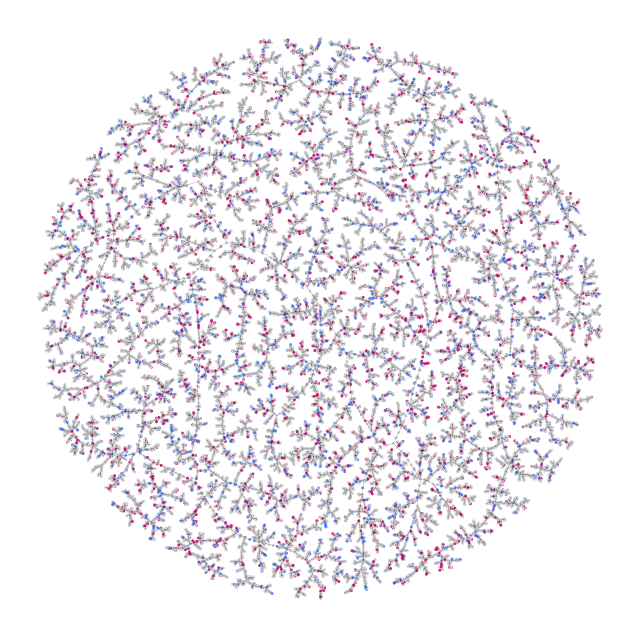

In [18]:
nstereo_colors = {'train': '#D6D6D6', 'validation': '#DC267F', 'test': '#648FFF'}
colors = coconut['split'].map(nstereo_colors)

x, y = tm_layout['x'], tm_layout['y']

plt.figure(figsize=(8, 8))
plt.scatter(x, y, s=1, c=colors)
for source, target in zip(tm_layout['s'], tm_layout['t']):
    plt.plot([x[source], x[target]], [y[source], y[target]], 'k-', linewidth=0.1)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])

plt.savefig('plots/tmaps/coconut_splits.png', dpi=1200, bbox_inches='tight')

TMAP: chemical classes

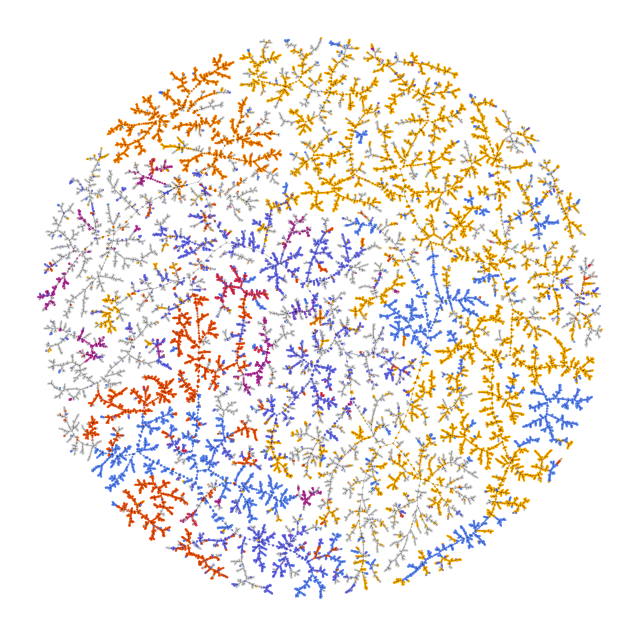

In [19]:
category_colors = {'Benzenoids': '#6F73F7', 'Nucleosides': '#8756E0', 'Alkaloids': '#BF36A0', 'Lignans': '#E6375A', 'Polyketides': '#F95812', 'Lipids & Terpenes': '#FFB000', 'Glycosides': '#648FFF', 'Peptides': '#FE8300', 'Other': '#D6D6D6'}
colors = coconut['chemical_class_new'].map(category_colors)

x, y = tm_layout['x'], tm_layout['y']

plt.figure(figsize=(8, 8))
plt.scatter(x, y, s=0.25, c=colors)
for source, target in zip(tm_layout['s'], tm_layout['t']):
    plt.plot([x[source], x[target]], [y[source], y[target]], 'k-', linewidth=0.1)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])

plt.savefig('plots/tmaps/coconut_chemical_classes.png', dpi=1200, bbox_inches='tight')

## Prediction Analysis

#### Import data frame

We use a custom function to read the predictions and add the different accuracy metrics to the data frame.

In [6]:
df_not_augmented = calculate_accuracies('not_augmented')
df_augmented_2x = calculate_accuracies('augmented_2x')
df_augmented_5x = calculate_accuracies('augmented_5x')
df_augmented_10x = calculate_accuracies('augmented_10x')
df_augmented_20x = calculate_accuracies('augmented_20x')
df_scrambled_5x = calculate_accuracies('scrambled_5x')

Add number of stereocenters to all data frames

In [8]:
def add_nstereo(df):
    df['#stereo'] = df['target'].apply(lambda x: len(get_stereocenters(Chem.MolFromSmiles(x))))
    df['#stereo'] = df['#stereo'].apply(lambda x: x if x <= 10 else 11)
    return df

df_not_augmented = add_nstereo(df_not_augmented)
df_augmented_2x = add_nstereo(df_augmented_2x)
df_augmented_5x = add_nstereo(df_augmented_5x)
df_augmented_10x = add_nstereo(df_augmented_10x)
df_augmented_20x = add_nstereo(df_augmented_20x)
df_scrambled_5x = add_nstereo(df_scrambled_5x)

#### Determine accuracies per stereocenter

Determining the accuracy of the predictions per stereocenter (up to 10)

In [9]:
df_not_augmented_accs = stereocenter_accuracies(df_not_augmented)
df_augmented_2x_accs = stereocenter_accuracies(df_augmented_2x)
df_augmented_5x_accs = stereocenter_accuracies(df_augmented_5x)
df_augmented_10x_accs = stereocenter_accuracies(df_augmented_10x)
df_augmented_20x_accs = stereocenter_accuracies(df_augmented_20x)
df_scrambled_5x_accs = stereocenter_accuracies(df_scrambled_5x)

Combine augmentations in a list

In [26]:
augmentation_dataframes = {'Not Augmented': df_not_augmented_accs, 
                           '2x Augmented': df_augmented_2x_accs, 
                           '5x Augmented': df_augmented_5x_accs, 
                           '10x Augmented': df_augmented_10x_accs, 
                           '20x Augmented': df_augmented_20x_accs, 
                           '5x Scrambled': df_scrambled_5x_accs}

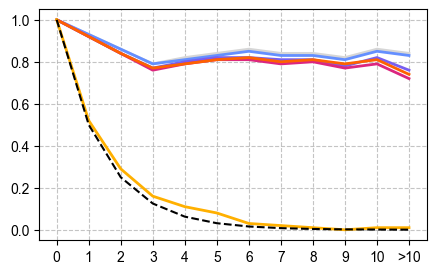

In [27]:
plt.figure(figsize=(5, 3))

colors = ['#D6D6D6', '#648FFF', '#785EF0', '#DC267F', '#FE6100', '#FFB000']

for (label, df), color in zip(augmentation_dataframes.items(), colors):
    plt.plot(df.index, df['top1'], label=label, color=color, linewidth=2)

x = np.arange(0, 12)
y = 1/2**x
plt.plot(x, y, color='black', linestyle='--', label='Random')

plt.xticks(ticks=np.arange(12), labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, '>10'])
plt.grid(True, linestyle='--', alpha=0.75)
plt.savefig('plots/stereocenter_accuracies.png', dpi=1200, bbox_inches='tight')

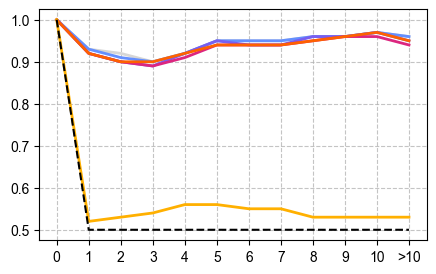

In [28]:
plt.figure(figsize=(5, 3))

colors = ['#D6D6D6', '#648FFF', '#785EF0', '#DC267F', '#FE6100', '#FFB000']

for (label, df), color in zip(augmentation_dataframes.items(), colors):
    plt.plot(df.index, df['top1_wt'], label=label, color=color, linewidth=2)

x = np.arange(0, 12)
y = [1 if _ == 0 else 0.5 for _ in x]
plt.plot(x, y, color='black', linestyle='--', label='Random')

plt.xticks(ticks=np.arange(12), labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, '>10'])
plt.grid(True, linestyle='--', alpha=0.75)
plt.savefig('plots/stereocenter_accuracies_wt.png', dpi=1200, bbox_inches='tight')

#### Determine accuracies per compound class

In [32]:
df_merged = df_not_augmented.merge(coconut[['smiles', 'chemical_class_new']], 
                                   left_on='target', 
                                   right_on='smiles', 
                                   how='left')

df_merged = df_merged.drop(columns=['smiles'])

Calculate mean and std deviation of stereocenters

In [34]:
df_merged_nstereo = df_merged.groupby('chemical_class_new')['#stereo'].agg(['mean', 'std']).reset_index()

Calculate compound class accuracies

In [35]:
def chemical_class_accuracies(df):
    accuracies = {  'top1': [],
                    'top2': [],
                    'top3': [],
                    'top1_wt': [],
                    'top2_wt': [],
                    'top3_wt': []
                  }
    categories = np.sort(df['chemical_class_new'].unique())
    for category in categories: 
        df_cat = df[df['chemical_class_new'] == category]
        accuracies['top1'].append(df_cat['top1'].mean())
        accuracies['top2'].append(df_cat['top2'].mean())
        accuracies['top3'].append(df_cat['top3'].mean())
        accuracies['top1_wt'].append(df_cat['top1_wt'].mean())
        accuracies['top2_wt'].append(df_cat['top2_wt'].mean())
        accuracies['top3_wt'].append(df_cat['top3_wt'].mean())
    
    accuracies = pd.DataFrame(accuracies)
    accuracies.index = categories
    accuracies = accuracies.sort_index()
    accuracies = accuracies.round(3)
    return accuracies

df_merged_accs = chemical_class_accuracies(df_merged)

Clean data frame

In [36]:
df_merged_accs['nstereo_mean'] = df_merged_nstereo['mean'].values.tolist()
df_merged_accs['nstereo_std'] = df_merged_nstereo['std'].values.tolist()
df_merged_accs = df_merged_accs.sort_values('top1', ascending=False)
df_merged_accs = df_merged_accs.drop('Other').append(df_merged_accs.loc['Other'])
df_merged_accs

,top1,top2,top3,top1_wt,top2_wt,top3_wt,nstereo_mean,nstereo_std
Polyketides,0.936,0.965,0.969,0.964,0.984,0.986,1.601942,2.167768
Benzenoids,0.931,0.968,0.974,0.972,0.991,0.992,1.777439,2.401496
Nucleosides,0.917,1.000,1.000,0.983,1.000,1.000,4.333333,0.651339
Alkaloids,0.884,0.912,0.925,0.944,0.962,0.965,3.074830,3.322997
Lignans,0.859,0.915,0.915,0.920,0.972,0.972,2.971831,1.740048
Peptides,0.856,0.921,0.924,0.944,0.962,0.962,8.206215,2.627996
Lipids & Terpenes,0.853,0.922,0.930,0.955,0.978,0.981,6.644737,3.077419
Glycosides,0.838,0.916,0.924,0.961,0.980,0.982,9.092649,2.379236
Other,0.867,0.921,0.930,0.940,0.969,0.974,3.628076,3.169485


Plot

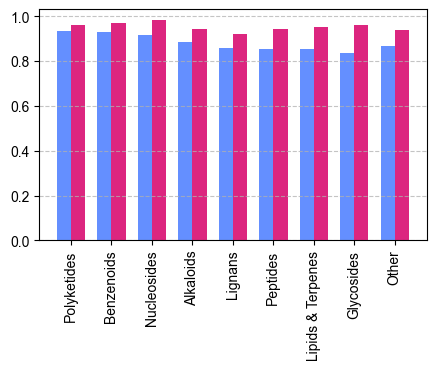

In [37]:
plt.figure(figsize=(5, 3))

bar_width = 0.35
index = np.arange(len(df_merged_accs))

plt.bar(index, df_merged_accs['top1'], bar_width, label='top1', color='#648FFF')
plt.bar(index + bar_width, df_merged_accs['top1_wt'], bar_width, label='top1_wt', color='#DC267F')

plt.xticks(index + bar_width / 2, df_merged_accs.index, rotation=90)
plt.grid(True, linestyle='--', alpha=0.75, axis='y')

plt.savefig('plots/chemical_class_accuracies.png', dpi=1200, bbox_inches='tight')